In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import seaborn as sns

# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))
from src.data.process_data import create_tmdb_dataset
from src.utils.load_data import load_raw_data
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.models.lda_model import *

[nltk_data] Downloading package stopwords to /Users/chsce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df = create_tmdb_dataset('data/processed/TMDB_clean.csv')
df.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate es...","[action, science fiction, adventure]","[legendary pictures, syncopy, warner bros. pic...","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, fran...",2010,during
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who mak...,"[adventure, drama, science fiction]","[legendary pictures, syncopy, lynda obst produ...","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time...",2014,post
2,the dark knight,2008-07-16,1004558444,152,185000000,en,batman raises the stakes in his war on crime. ...,"[drama, action, crime, thriller]","[dc comics, legendary pictures, syncopy, isobe...","[united kingdom, united states of america]","[english, mandarin]","[joker, sadism, chaos, secret identity, crime ...",2008,during
3,avatar,2009-12-15,2923706026,162,237000000,en,"in the 22nd century, a paraplegic marine is di...","[action, adventure, fantasy, science fiction]","[dune entertainment, lightstorm entertainment,...","[united states of america, united kingdom]","[english, spanish]","[future, society, culture clash, space travel,...",2009,during
4,the avengers,2012-04-25,1518815515,143,220000000,en,when an unexpected enemy emerges and threatens...,"[science fiction, action, adventure]",[marvel studios],[united states of america],"[english, hindi, russian]","[new york city, superhero, shield, based on co...",2012,during


In [12]:
def calculate_roi(df):
    if df.revenue > 0 and df.budget > 0:
        return (df.revenue - df.budget) / df.budget
    else: 
        return 0
    
df['roi'] = df.apply(calculate_roi, axis=1)

In [13]:
df[(df.roi > 0) & (df.roi <)].groupby('release_year').agg(mean_roi=('roi', 'mean'))

,mean_roi
release_year,
1976,13.829175
1977,20.115389
1978,16.866679
1979,12.260161
1980,7.816957
1981,6.837634
1982,5.487165
1983,9.714247
1984,5.979220


In [46]:
df[df.roi > 0].roi.describe()

count    5.967000e+03
mean     4.551717e+03
std      2.616492e+05
min      2.000000e-06
25%      8.139292e-01
50%      1.941176e+00
75%      4.415662e+00
max      2.000000e+07
Name: roi, dtype: float64

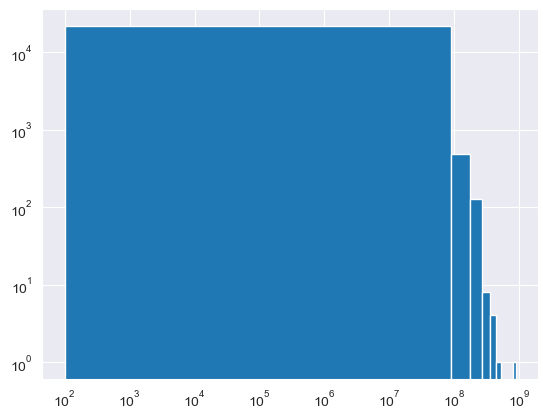

In [22]:
plt.hist(df[df.budget >100].budget)
plt.xscale('log')
plt.yscale('log')
plt.show()

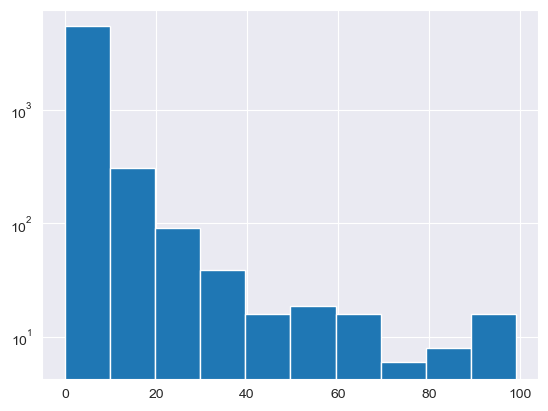

In [51]:
plt.hist(df[(df.roi > 0) & (df.roi < 1e2)].roi)
plt.yscale('log')

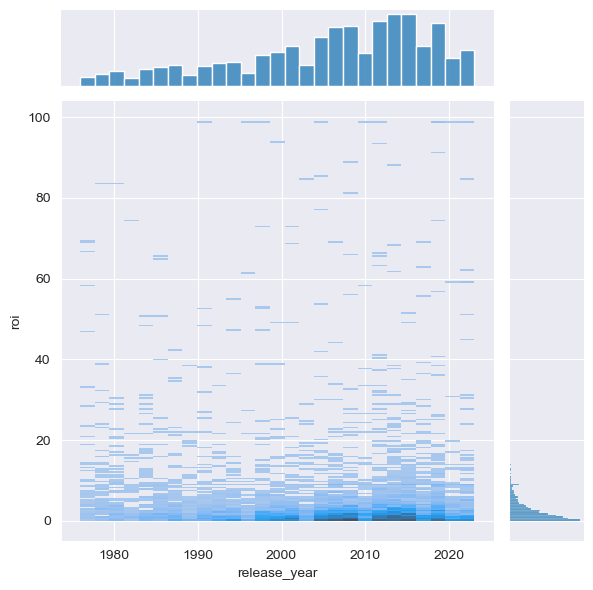

In [55]:
sns.jointplot(x='release_year', y='roi', data=df[(df.roi > 0) & (df.roi < 1e2)], kind='hist')
plt.show()

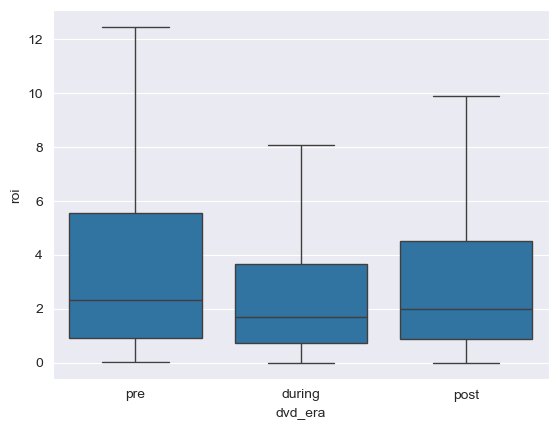

In [59]:
sns.boxplot(data=df[(df.roi > 0) & (df.roi < 100)], x='dvd_era', y='roi', showfliers=False, order=['pre', 'during', 'post'])
plt.show()

In [90]:
mean_budgets = df[df.budget > 0].groupby('release_year').agg(mean_budget = ('budget', 'mean'))

def categorize_production(row, means):
    mean_budget = means.loc[row.release_year, 'mean_budget']
    if row['budget'] < 0.1 * mean_budget:
        return 'Independent'
    elif row['budget'] < mean_budget:
        return 'Small'
    elif row['budget'] < 5 * mean_budget:
        return 'Big'
    else:
        return 'Super'
    
df['prod_type'] = df.apply(categorize_production, axis=1, args=(mean_budgets,))

In [105]:
contingency_table = pd.crosstab(df[df.budget >0]['dvd_era'], df[df.budget >0]['prod_type']).reindex(['pre', 'during', 'post'])[['Independent', 'Small', 'Big', 'Super']]
print(contingency_table)


prod_type  Independent  Small   Big  Super
dvd_era                                   
pre                858   1049  1092     43
during            4100   3048  1874    431
post              7214   2494  1287    580


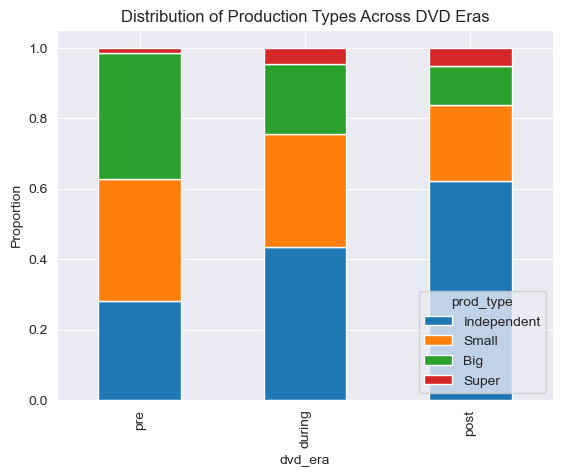

In [106]:
era_proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)
era_proportions.plot(kind='bar', stacked=True)
plt.ylabel('Proportion')
plt.title('Distribution of Production Types Across DVD Eras')
plt.show()

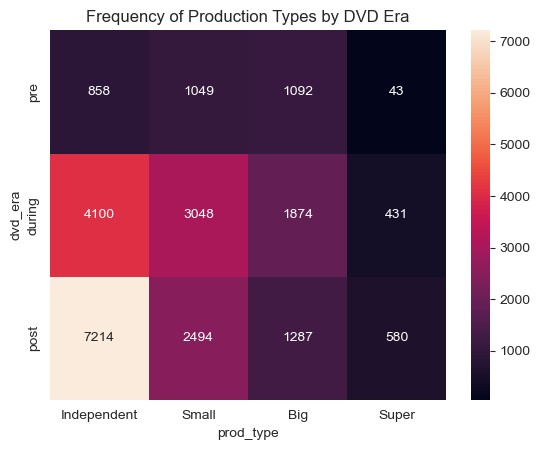

In [108]:
sns.heatmap(contingency_table, annot=True, fmt="d")
plt.title("Frequency of Production Types by DVD Era")
plt.show()

In [109]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
if p < 0.05:
    print("Significant differences in production type distributions across DVD eras.")
else:
    print("No significant differences found.")

Chi-Square Statistic: 1945.862082377144
P-Value: 0.0
Significant differences in production type distributions across DVD eras.


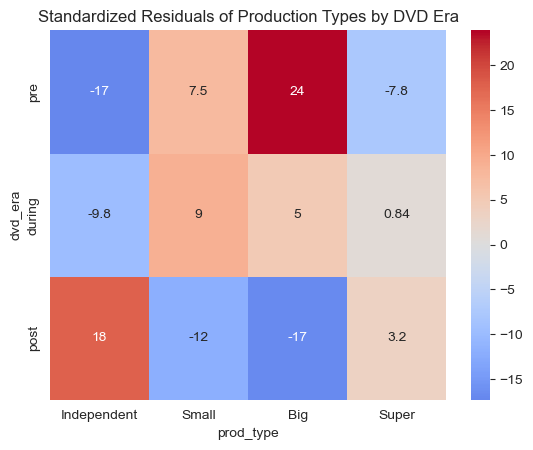

In [110]:
import numpy as np

residuals = (contingency_table - expected) / np.sqrt(expected)
sns.heatmap(residuals, annot=True, cmap="coolwarm", center=0)
plt.title("Standardized Residuals of Production Types by DVD Era")
plt.show()


In [113]:
from statsmodels.stats.proportion import proportions_ztest

count = contingency_table['Super']
total = contingency_table.sum(axis=1)
z_stat, p_value = proportions_ztest([count['pre'], count['during']], [total['pre'], total['during']])
print(f"Z-Statistic: {z_stat}, P-Value: {p_value}")


Z-Statistic: -7.899722804486404, P-Value: 2.7952435919950132e-15


In [135]:
movies = df.copy()
# Explode the genres column
movies_exploded = movies.explode('genres')
movies['dvd_era'] = pd.Categorical(movies['dvd_era'], categories=['pre', 'during', 'post'], ordered=True)
movies['prod_type'] = pd.Categorical(movies['prod_type'], categories=['Independent', 'Small', 'Big', 'Super'], ordered=True)
# Verify the expanded data
movies_exploded.head()

,title,release_date,revenue,runtime,budget,original_language,overview,genres,production_companies,production_countries,spoken_languages,keywords,release_year,dvd_era,roi,prod_type
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.",action,"[legendary pictures, syncopy, warner bros. pictures]","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious]",2010,during,4.159580,Super
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.",science fiction,"[legendary pictures, syncopy, warner bros. pictures]","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious]",2010,during,4.159580,Super
0,inception,2010-07-15,825532764,148,160000000,en,"cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: ""inception"", the implantation of another person's idea into a target's subconscious.",adventure,"[legendary pictures, syncopy, warner bros. pictures]","[united kingdom, united states of america]","[english, french, japanese, swahili]","[rescue, mission, dream, airplane, paris, france, virtual reality, kidnapping, philosophy, spy, allegory, manipulation, car crash, heist, memory, architecture, los angeles, california, dream world, subconscious]",2010,during,4.159580,Super
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.,adventure,"[legendary pictures, syncopy, lynda obst productions]","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time, artificial intelligence (a.i.), nasa, time warp, dystopia, expedition, space travel, wormhole, famine, black hole, quantum mechanics, family relationships, space, robot, astronaut, scientist, single father, farmer, space station, curious, space adventure, time paradox, thoughtful, time-manipulation, father daughter relationship, 2060s, cornfield, time manipulation, complicated]",2014,post,3.252904,Super
1,interstellar,2014-11-05,701729206,169,165000000,en,the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.,drama,"[legendary pictures, syncopy, lynda obst productions]","[united kingdom, united states of america]",[english],"[rescue, future, spacecraft, race against time, artificial intelligence (a.i.), nasa, time warp, dystopia, expedition, space travel, wormhole, famine, black hole, quantum mechanics, family relationships, space, robot, astronaut, scientist, single father, farmer, space station, curious, space adventure, time paradox, thoughtful, time-manipulation, father daughter relationship, 2060s, cornfield, time manipulation, complicated]",2014,post,3.2

In [136]:
# Count occurrences of each genre within production types and DVD eras
genre_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era', 'genres'])
    .size()
    .reset_index(name='count')
)

# Total count of genres per production type and DVD era
total_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era'])
    .size()
    .reset_index(name='total')
)

# Merge to compute proportions
genre_proportions = genre_counts.merge(
    total_counts,
    on=['prod_type', 'dvd_era']
)
genre_proportions['proportion'] = (
    genre_proportions['count'] / genre_proportions['total']
)


In [157]:
genre_proportions

,prod_type,dvd_era,genres,count,total,proportion
0,Big,during,action,506,5066,0.099882
1,Big,during,adventure,309,5066,0.060995
2,Big,during,animation,96,5066,0.018950
3,Big,during,comedy,706,5066,0.139360
4,Big,during,crime,337,5066,0.066522
...,...,...,...,...,...,...
210,Super,pre,romance,2,125,0.016000
211,Super,pre,science fiction,12,125,0.096000
212,Super,pre,thriller,12,125,0.096000
213,Super,pre,war,6,125,0.048000


In [148]:
mindex = pd.MultiIndex.from_arrays([['Independent','Independent', 'Independent', 'Small','Small','Small', 'Big','Big','Big', 'Super', 'Super', 'Super'], ['pre', 'during', 'post']*4], names=('prod_type', 'dvd_era'))

/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_42955/2945129020.py:5: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



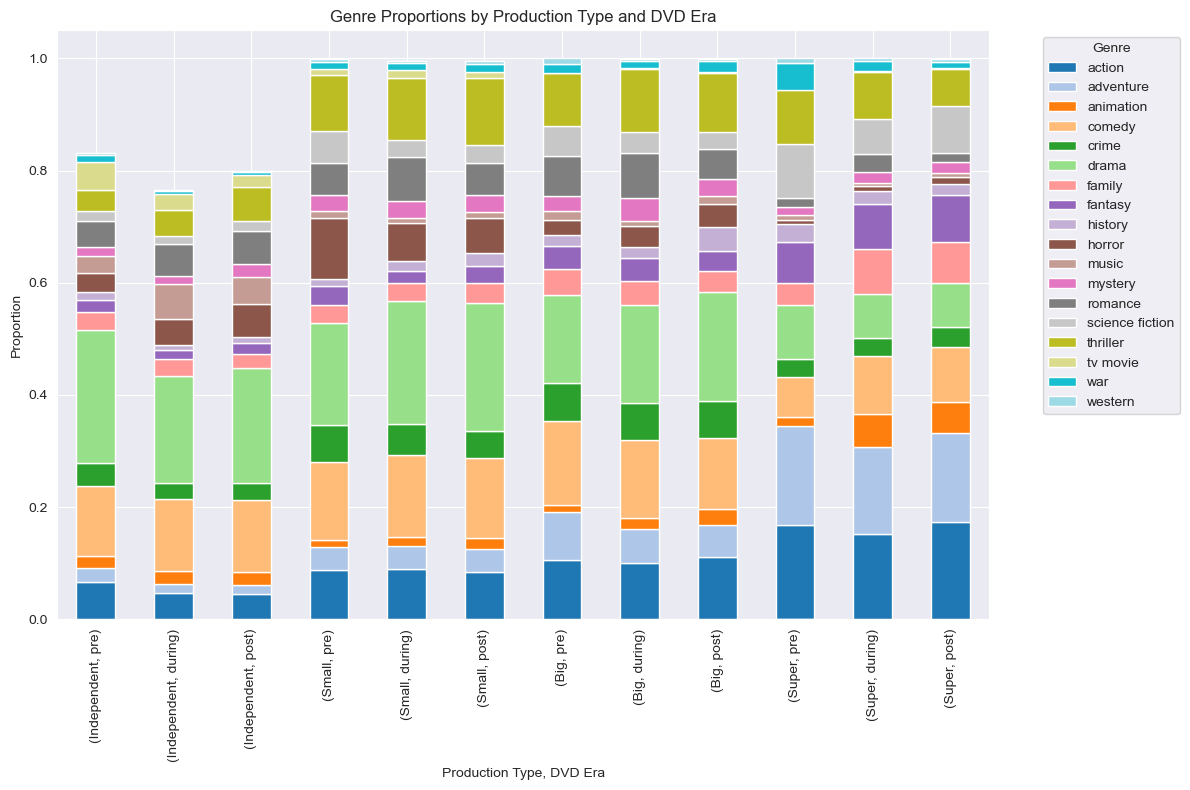

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot data for easier plotting
pivot_data = genre_proportions.pivot_table(
    index=['prod_type', 'dvd_era'],
    columns='genres',
    values='proportion',
    fill_value=0
).reindex(mindex)

# Plot
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20'
)
plt.title('Genre Proportions by Production Type and DVD Era')
plt.xlabel('Production Type, DVD Era')
plt.ylabel('Proportion')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_42955/2374235087.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



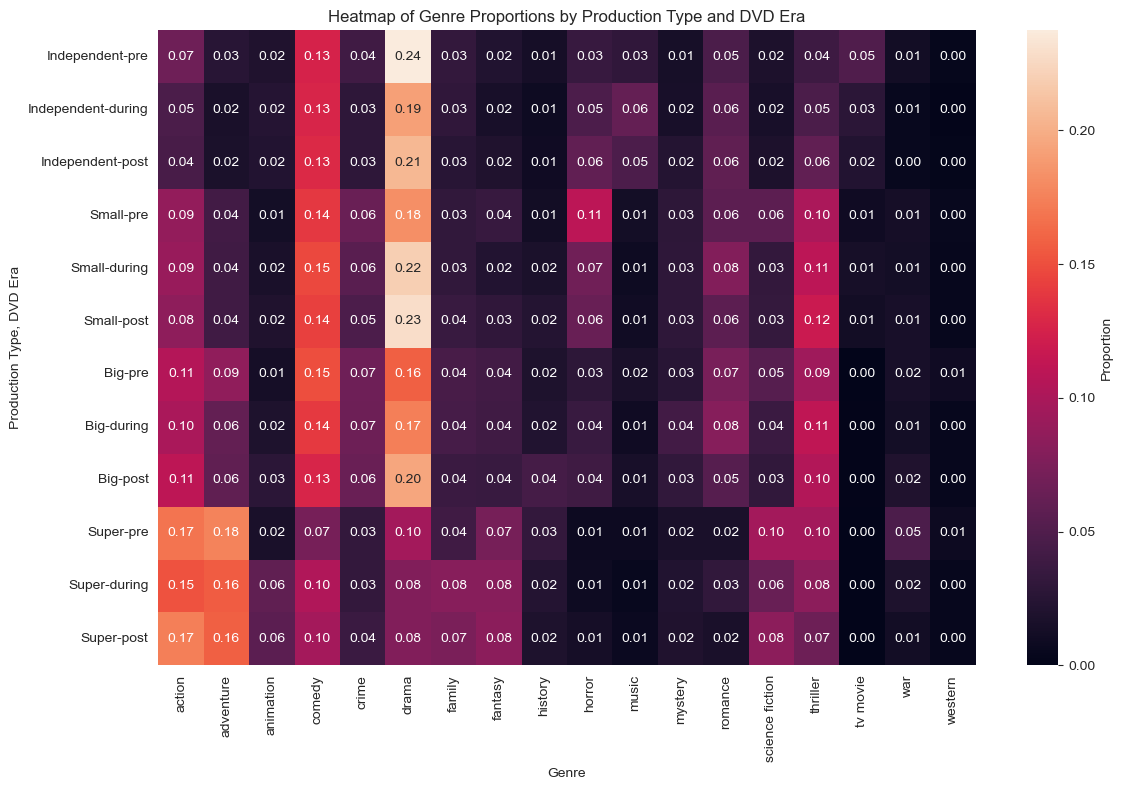

In [165]:
# Create a pivot table
heatmap_data = genre_proportions.pivot_table(
    index=['prod_type', 'dvd_era'],
    columns='genres',
    values='proportion',
    fill_value=0
).reindex(mindex)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Proportion'}
)
plt.title('Heatmap of Genre Proportions by Production Type and DVD Era')
plt.xlabel('Genre')
plt.ylabel('Production Type, DVD Era')
plt.tight_layout()
plt.show()



In [164]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

# Explode the genres list (if genres are stored in a list, here we just have one genre per movie for simplicity)
movies_exploded = movies.explode('genres')


# Count the occurrences of genres by prod_type and dvd_era
genre_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era', 'genres'])
    .size()
    .reset_index(name='count')
)

# Get total counts per prod_type and dvd_era combination
total_counts = (
    movies_exploded.groupby(['prod_type', 'dvd_era'])
    .size()
    .reset_index(name='total')
)

# Merge counts with totals to calculate proportions
genre_proportions = genre_counts.merge(total_counts, on=['prod_type', 'dvd_era'])
genre_proportions['proportion'] = genre_proportions['count'] / genre_proportions['total']

# Create a pivot table for the heatmap
pivot_data = genre_proportions.pivot_table(
    index='prod_type',  # This will be on y-axis
    columns='dvd_era',  # This will be on x-axis
    values='proportion',
    fill_value=0
)

# Define the interactive plot function
def plot_heatmap(fixed_value, fixed_type='prod_type'):
    if fixed_type == 'prod_type':
        filtered_data = genre_proportions[genre_proportions['prod_type'] == fixed_value]
    else:
        filtered_data = genre_proportions[genre_proportions['dvd_era'] == fixed_value]

    pivot_filtered = filtered_data.pivot_table(
        index='prod_type' if fixed_type == 'dvd_era' else 'dvd_era', 
        columns='genres', 
        values='proportion', 
        fill_value=0, 
        observed=False
    )

    # Create a heatmap
    fig = px.imshow(
        pivot_filtered,
        color_continuous_scale='Blues',
        labels={'x': 'Genre', 'y': 'Production Type' if fixed_type == 'dvd_era' else 'DVD Era'},
        title=f'Heatmap for {fixed_value} ({fixed_type})',
        text_auto=True,
    )

    fig.show()
    plt.show()

# Create widgets for selection
prod_type_selector = widgets.Dropdown(
    options=movies['prod_type'].unique(),
    description='Production Type:'
)

dvd_era_selector = widgets.Dropdown(
    options=movies['dvd_era'].unique(),
    description='DVD Era:'
)

# Set up the interactive widget
interact(plot_heatmap, fixed_value=prod_type_selector, fixed_type=widgets.fixed('prod_type'))



/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_42955/2361258598.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_42955/2361258598.py:19: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/d3/9chl4s4x2w1dxn5y2k9m88fc0000gn/T/ipykernel_42955/2361258598.py:29: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



interactive(children=(Dropdown(description='Production Type:', options=('Super', 'Big', 'Small', 'Independent'…

<function __main__.plot_heatmap(fixed_value, fixed_type='prod_type')>

In [166]:
interact(plot_heatmap, fixed_value=dvd_era_selector, fixed_type=widgets.fixed('dvd_era'))

interactive(children=(Dropdown(description='DVD Era:', options=('during', 'post', 'pre'), value='during'), Out…

<function __main__.plot_heatmap(fixed_value, fixed_type='prod_type')>

In [180]:
pivot_data.loc['Small']

genres,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
dvd_era,,,,,,,,,,,,,,,,,,
pre,0.087648,0.041582,0.012638,0.139013,0.064819,0.182634,0.031390,0.035059,0.011822,0.109662,0.012638,0.028129,0.056665,0.056665,0.100285,0.009784,0.013045,0.004892
during,0.090211,0.040268,0.015936,0.147126,0.055350,0.218839,0.031161,0.022197,0.017359,0.068441,0.009249,0.029311,0.077974,0.031873,0.109562,0.014087,0.012948,0.004126
post,0.084845,0.040627,0.019652,0.142857,0.047808,0.228647,0.035336,0.029856,0.023054,0.063303,0.010960,0.029289,0.057256,0.032880,0.117914,0.011338,0.014928,0.004535


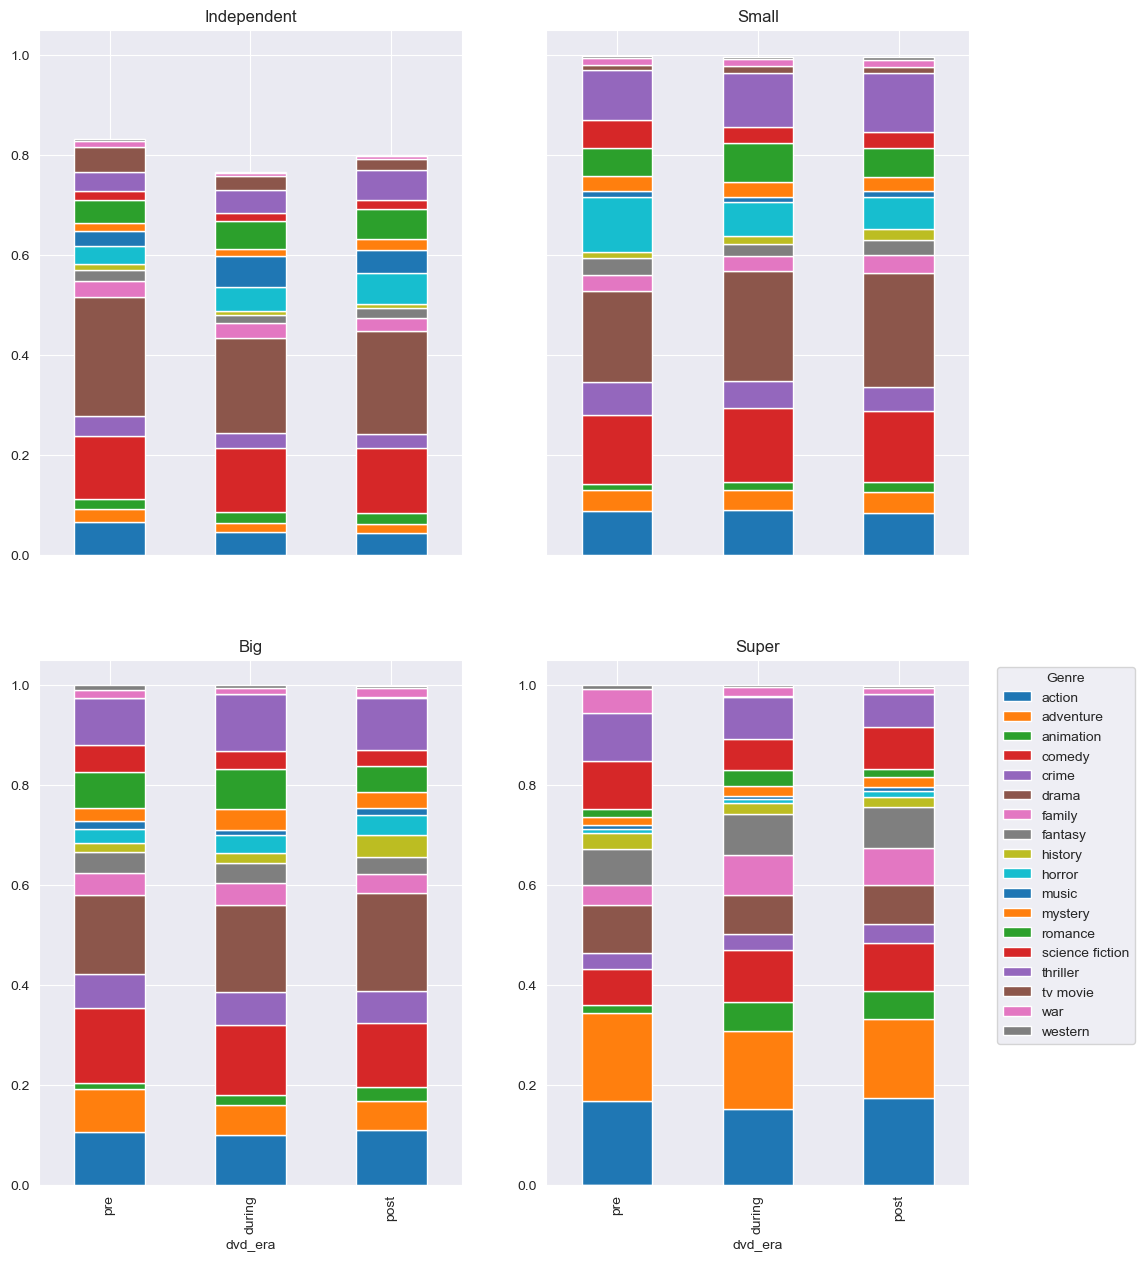

In [192]:
f, axs = plt.subplots(2, 2, figsize=(12, 15), sharex=True, sharey=True)


for ax, prod in zip(axs.flatten(), genre_proportions.prod_type.unique()):
    data_prod = pivot_data.loc[prod]
    data_prod.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.tick_params(axis='both', which='both', labelbottom=True, labelleft=True)
    ax.set_title(prod)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()